In [1]:
import os
print(os.getcwd())  # check local
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import cartopy.mpl.ticker as cticker
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import metpy
import scipy.stats as sts
from glob import glob
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import re
import warnings
import isca_tools
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils import area_weighting, lat_lon_coord_slice
from isca_tools.utils.base import round_any
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.convection.base import lcl_metpy, dry_profile_temp, moist_profile
from isca_tools.thesis.adiabat_theory import get_z_ft_approx
from isca_tools.thesis.lapse_theory import get_bulk_lapse_rate, reconstruct_temp, interp_var_at_pressure
from isca_tools.utils.moist_physics import sphum_sat, moist_static_energy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from matplotlib.patches import Ellipse
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/joshduffield/Documents/StAndrews/Isca/jobs/theory_lapse


/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7


plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

In [3]:
def get_co2_multiplier(name):
    match = re.match(r'co2_([\d_]+)x', name)
    if match:
        # Replace underscore with decimal point and convert to float
        return float(match.group(1).replace('_', '.'))
    elif name == 'pre_industrial':
        return 1  # for pre_industrial or other defaults
    else:
        raise ValueError(f'Not valid name = {name}')

In [4]:
exp_name = ['pre_industrial', 'co2_2x']
# exp_name = ['co2_2x', 'co2_4x']
n_exp = len(exp_name)
exp_path = lambda x: f'/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/theory_adiabat/above_quant_2m_500hPa/{x}/all_days/output_lev_quant95_with_precip.nd2'
ds = [xr.open_dataset(exp_path(var)).isel(quant=0) for var in exp_name]
ds = xr.concat(ds, dim=xr.DataArray([get_co2_multiplier(exp_name[i]) for i in range(n_exp)], name='co2', dims='co2'))

In [5]:
# Land masks
# The year for the land-sea mask matters. Not surprising due to glaciers melting. Zhang used 1979 mask.
invariant_data = xr.open_dataset('/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/input_data/fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_sgh30_24km_GRNL_c170103.nc')[['LANDFRAC', 'PHIS']]
invariant_data = invariant_data.reindex_like(ds['PS'], method="nearest", tolerance=0.01).load()
# lsm = lsm_zhang
land = invariant_data['LANDFRAC'].where(invariant_data['LANDFRAC']>0.5)*0+1
ocean = invariant_data['LANDFRAC'].where(invariant_data['LANDFRAC']<=0.5)*0+1
weights = np.cos(np.deg2rad(invariant_data.lat))
z2m = invariant_data.PHIS/g + 2

In [6]:
def initialize_ax_projection(ax, lon_min=-180, lon_max=180, lat_min=30, lat_max=80,
                             grid_lon=np.arange(-180,180.01,60), grid_lat=np.asarray([40, 65])):
    ax.coastlines(color='k', linewidth=1)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    gl = ax.gridlines(ccrs.PlateCarree(), xlocs=grid_lon, ylocs=grid_lat, linestyle=':',
                      color='k', alpha=1, draw_labels=True)
    gl.right_labels=0
    gl.top_labels=0
    return ax

def plot_contour_projection(ax, var, levels=None, n_levels=10, mask=land, cmap='viridis'):
    data, lon = add_cyclic_point(var * (1 if mask is None else mask), coord=var.lon.values, axis=1)
    if levels is None:
        levels = np.linspace(var.min(), var.max(), n_levels)
    im = ax.contourf(lon, var.lat.values, data, transform=ccrs.PlateCarree(),
                     levels=levels, extend='both', cmap=cmap)
    return im

In [7]:
# Account for regions where LCL outside the range between REFHT and pressure_ft
pressure_ft = 500 * 100
# Replace T_at_lcl with TREFHT wherever p_at_lcl closer to surface than PREFHT
ds['T_at_lcl'] = ds['T_at_lcl'].where(ds.p_at_lcl < ds.PREFHT, ds.TREFHT)
ds['T_at_lcl'] = ds['T_at_lcl'].where(ds.p_at_lcl > pressure_ft, ds.T_zonal_av+ds.T_anom)         # where p_at_lcl further from surface than FT, set to FT
# Do same with p_at_lcl
ds['p_at_lcl'] = ds['p_at_lcl'].where(ds.p_at_lcl < ds.PREFHT, ds.PREFHT)
ds['p_at_lcl'] = ds['p_at_lcl'].where(ds.p_at_lcl > pressure_ft, pressure_ft)
ds['sigma_at_lcl'] = ds['p_at_lcl'] / ds.PREFHT

In [8]:
ds['T_ft'] = ds.T_zonal_av+ds.T_anom
ds['lapse_below_lcl'] = get_bulk_lapse_rate(ds.TREFHT, ds.T_at_lcl, ds.PREFHT, ds.p_at_lcl) * 1000
ds['lapse_below_lcl'] = ds['lapse_below_lcl'].where(ds.p_at_lcl < ds.PREFHT, 0)         # set to 0 where p_at_lcl = PREFHT
ds['lapse_above_lcl'] = get_bulk_lapse_rate(ds.T_at_lcl, ds['T_ft'], ds.p_at_lcl, pressure_ft) * 1000
ds['lapse_above_lcl'] = ds['lapse_above_lcl'].where(ds.p_at_lcl > pressure_ft, 0)         # set to 0 where p_at_lcl = pressure_ft

In [9]:
# R_mod = R * np.log(ds.PREFHT / pressure_ft) / 2
# z500_minus_ZREFHT_approx = R_mod/g * (ds.TREFHT + ds.T_ft)
# Get mse at REFHT minus MSE at FT
# ds['mse_lapse'] = c_p * ds.TREFHT + L_v * ds.QREFHT - (c_p * ds.T_ft + L_v * sphum_sat(ds.T_ft, pressure_ft)) - g * z500_minus_ZREFHT_approx
ds['mse_lapse'] = moist_static_energy(ds.TREFHT, ds.QREFHT, ds.ZREFHT) - moist_static_energy(ds.T_ft, sphum_sat(ds.T_ft, pressure_ft), ds.Z3)

ds['QREFHT5'] = ds['QREFHT'] - ds['mse_lapse'].isel(plev=0) * 1000 / L_v
ds['rh_REFHT'] = ds['QREFHT'] / sphum_sat(ds.TREFHT, ds.PREFHT)
ds['rh_REFHT5'] = ds['QREFHT5'] / sphum_sat(ds.TREFHT, ds.PREFHT)
ds['p_lcl5'], ds['T_lcl5'] = lcl_metpy(ds.TREFHT.fillna(0), ds.QREFHT5.fillna(0), ds.PREFHT.fillna(0))

### Fraction of days convective
Below I plot how the fraction of days identified as convective changes with warming. All white regions are always convective.

In [10]:
n_sample = (~np.isnan(ds.TREFHT)).sum(dim='sample')
ds['is_conv'] = ds.p_lcl5 < ds.PREFHT
# only show regions which have at least 5% non-convective days in one sim
show_conv = (ds.is_conv.sum(dim='sample')/n_sample).min(dim='co2') < 0.95

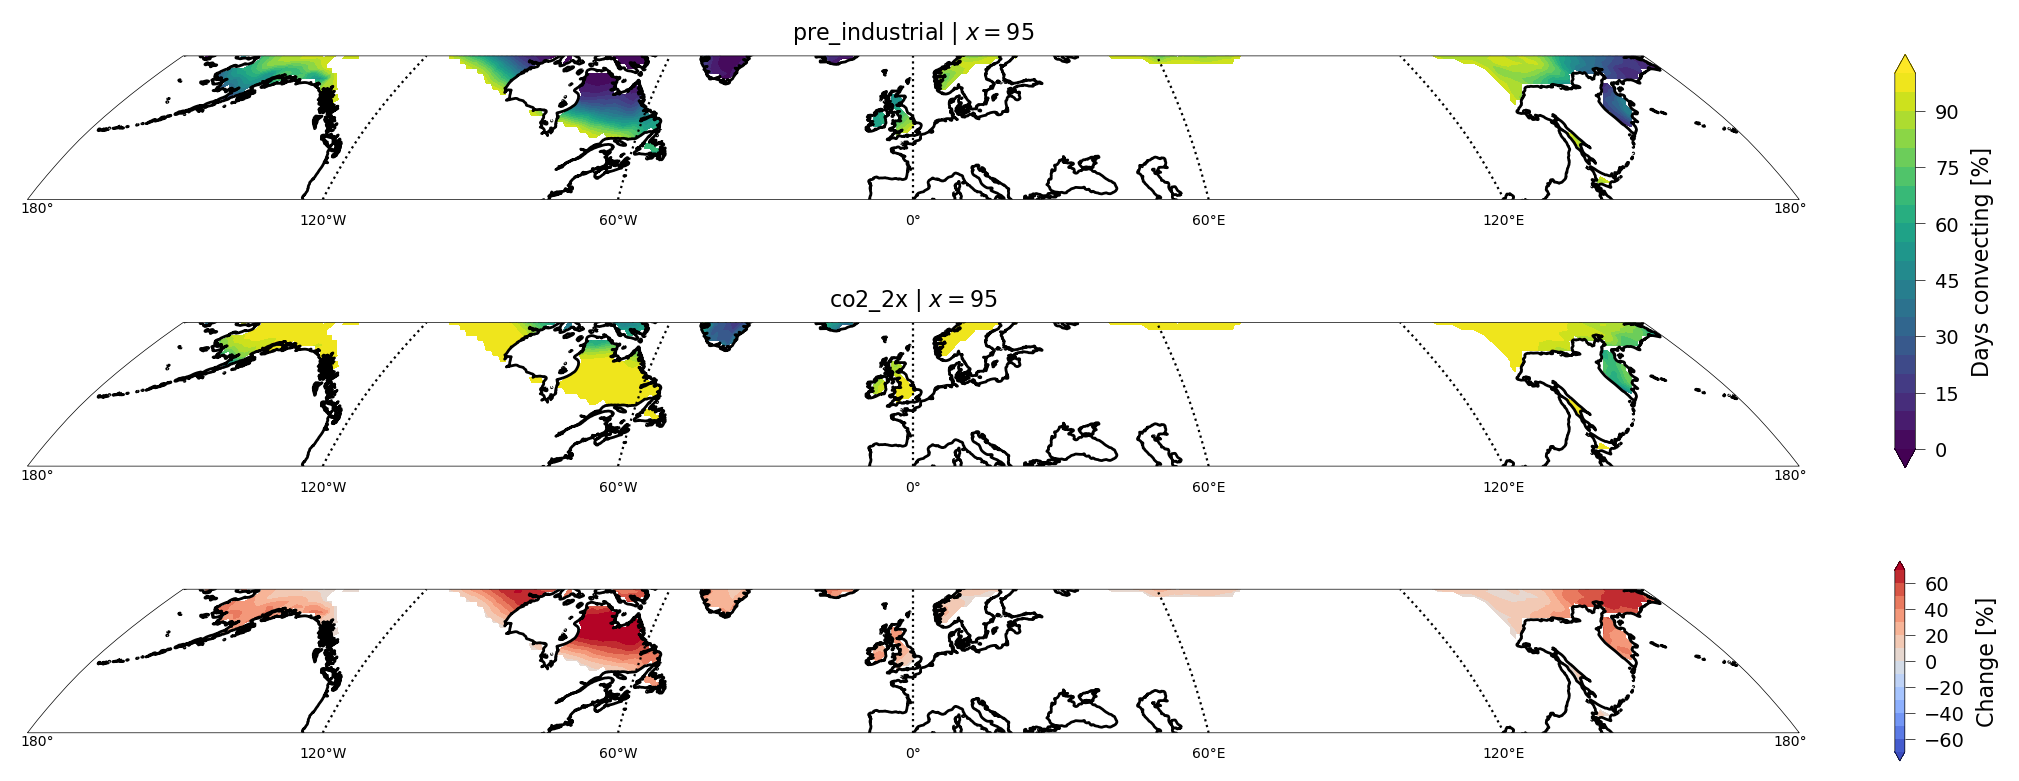

In [11]:
lat_min = 40
lat_max = 65
fig = plt.figure(constrained_layout=True,figsize=(10.,4))
ax = fig.subplots(3, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})

for i in range(n_exp):
    initialize_ax_projection(ax[i], lat_min=lat_min, lat_max=lat_max)
    im = plot_contour_projection(ax[i], (ds.is_conv.sum(dim='sample')/n_sample).isel(co2=i) * 100,
                                 levels=np.arange(0, 1.05, 0.05)*100, cmap='viridis', mask = land.where(show_conv))
    ax[i].set_title(f"{exp_name[i]} | $x={ds.quant:.0f}$")
plt.colorbar(im, ax=ax[:2].ravel(), label='Days convecting [%]', shrink=0.8)
initialize_ax_projection(ax[2], lat_min=lat_min, lat_max=lat_max)
im = plot_contour_projection(ax[2], (ds.is_conv.sum(dim='sample')/n_sample).isel(co2=1) * 100 -
                             (ds.is_conv.sum(dim='sample')/n_sample).isel(co2=0) * 100,
                             levels=np.arange(-0.7, 0.8, 0.1)*100, cmap='coolwarm', mask = land.where(show_conv))
plt.colorbar(im, ax=ax[2:].ravel(), label='Change [%]', shrink=0.8)
plt.show()

#### Comparison to precipitation
As a sanity check that this is a good measure of convection, I plot below the fraction of total precipitation that is convective. This again seems to increase in the same regions. I only plot regions with a significant amount of total precipitation.

In [12]:
precip_frac = ds.PRECC.mean(dim='sample') / (ds.PRECC.mean(dim='sample') + ds.PRECL.mean(dim='sample'))
precip_thresh = 1e-8
show_precip = (ds.PRECC.mean(dim='sample') + ds.PRECL.mean(dim='sample')).min(dim='co2') > precip_thresh

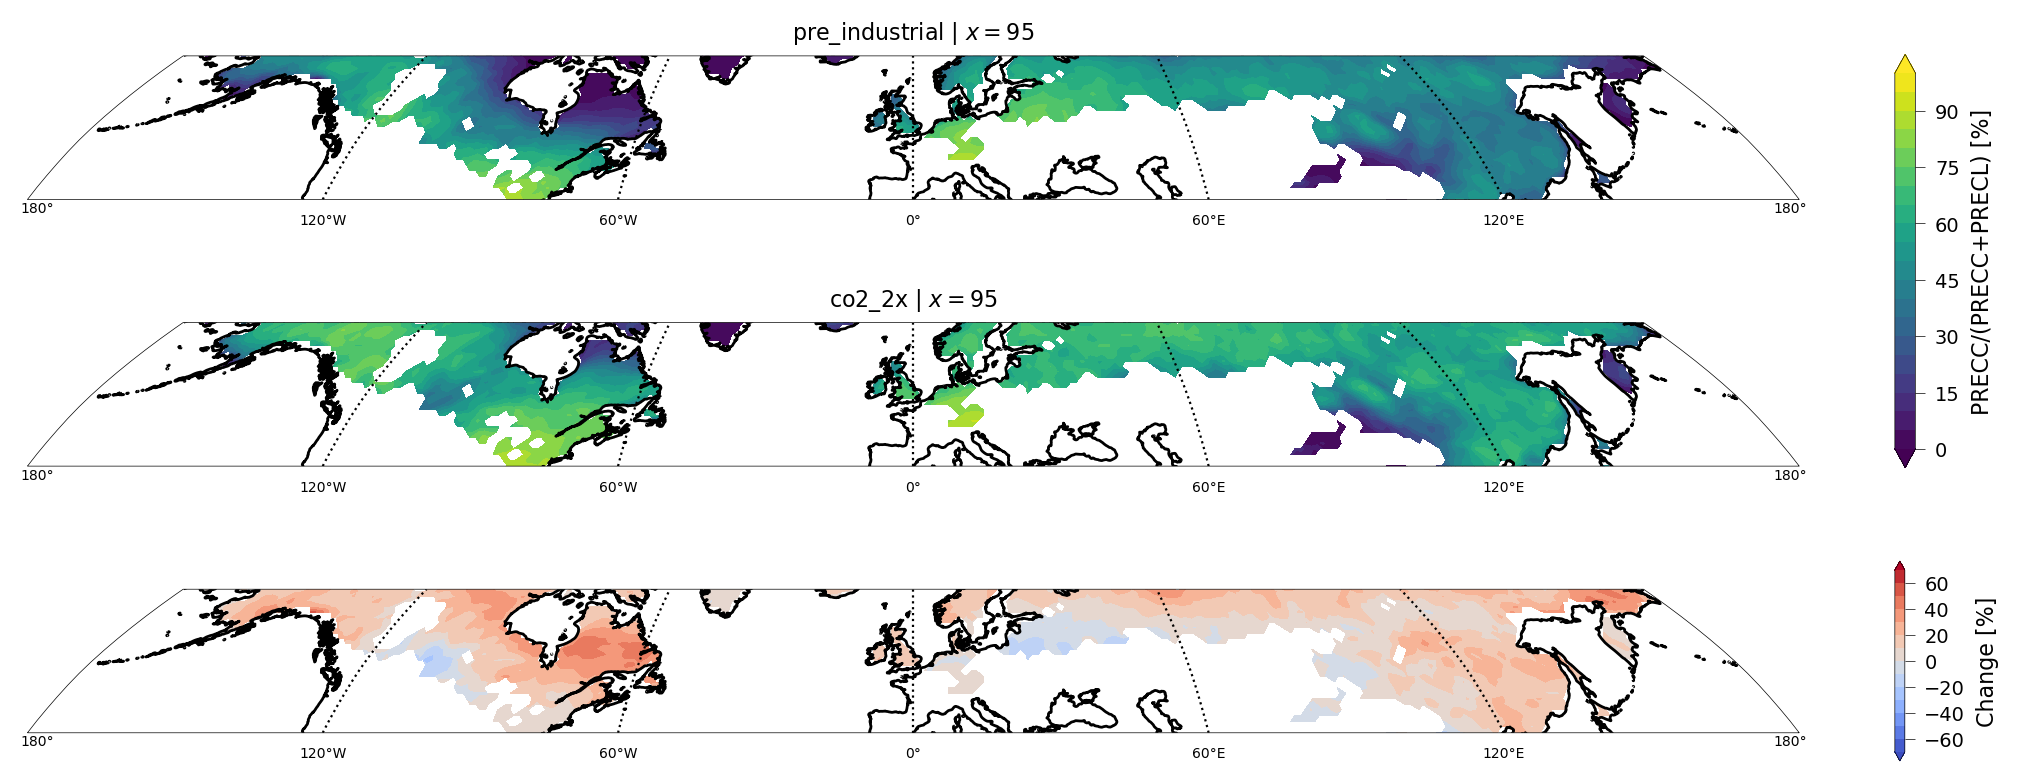

In [13]:
fig = plt.figure(constrained_layout=True,figsize=(10.,4))
ax = fig.subplots(3, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})

for i in range(n_exp):
    initialize_ax_projection(ax[i], lat_min=lat_min, lat_max=lat_max)
    im = plot_contour_projection(ax[i], precip_frac.isel(co2=i) * 100,
                                 levels=np.arange(0, 1.05, 0.05)*100, cmap='viridis', mask = land.where(show_precip))
    ax[i].set_title(f"{exp_name[i]} | $x={ds.quant:.0f}$")
plt.colorbar(im, ax=ax[:2].ravel(), label='PRECC/(PRECC+PRECL) [%]', shrink=0.8)
initialize_ax_projection(ax[2], lat_min=lat_min, lat_max=lat_max)
im = plot_contour_projection(ax[2], precip_frac.isel(co2=1) * 100 -
                             precip_frac.isel(co2=0) * 100,
                             levels=np.arange(-0.7, 0.8, 0.1)*100, cmap='coolwarm', mask = land.where(show_precip))
plt.colorbar(im, ax=ax[2:].ravel(), label='Change [%]', shrink=0.8)
plt.show()

### Temperature conditioned on convective days
Below I show convective days are warmer than the non-convective days, especially around north east North America.

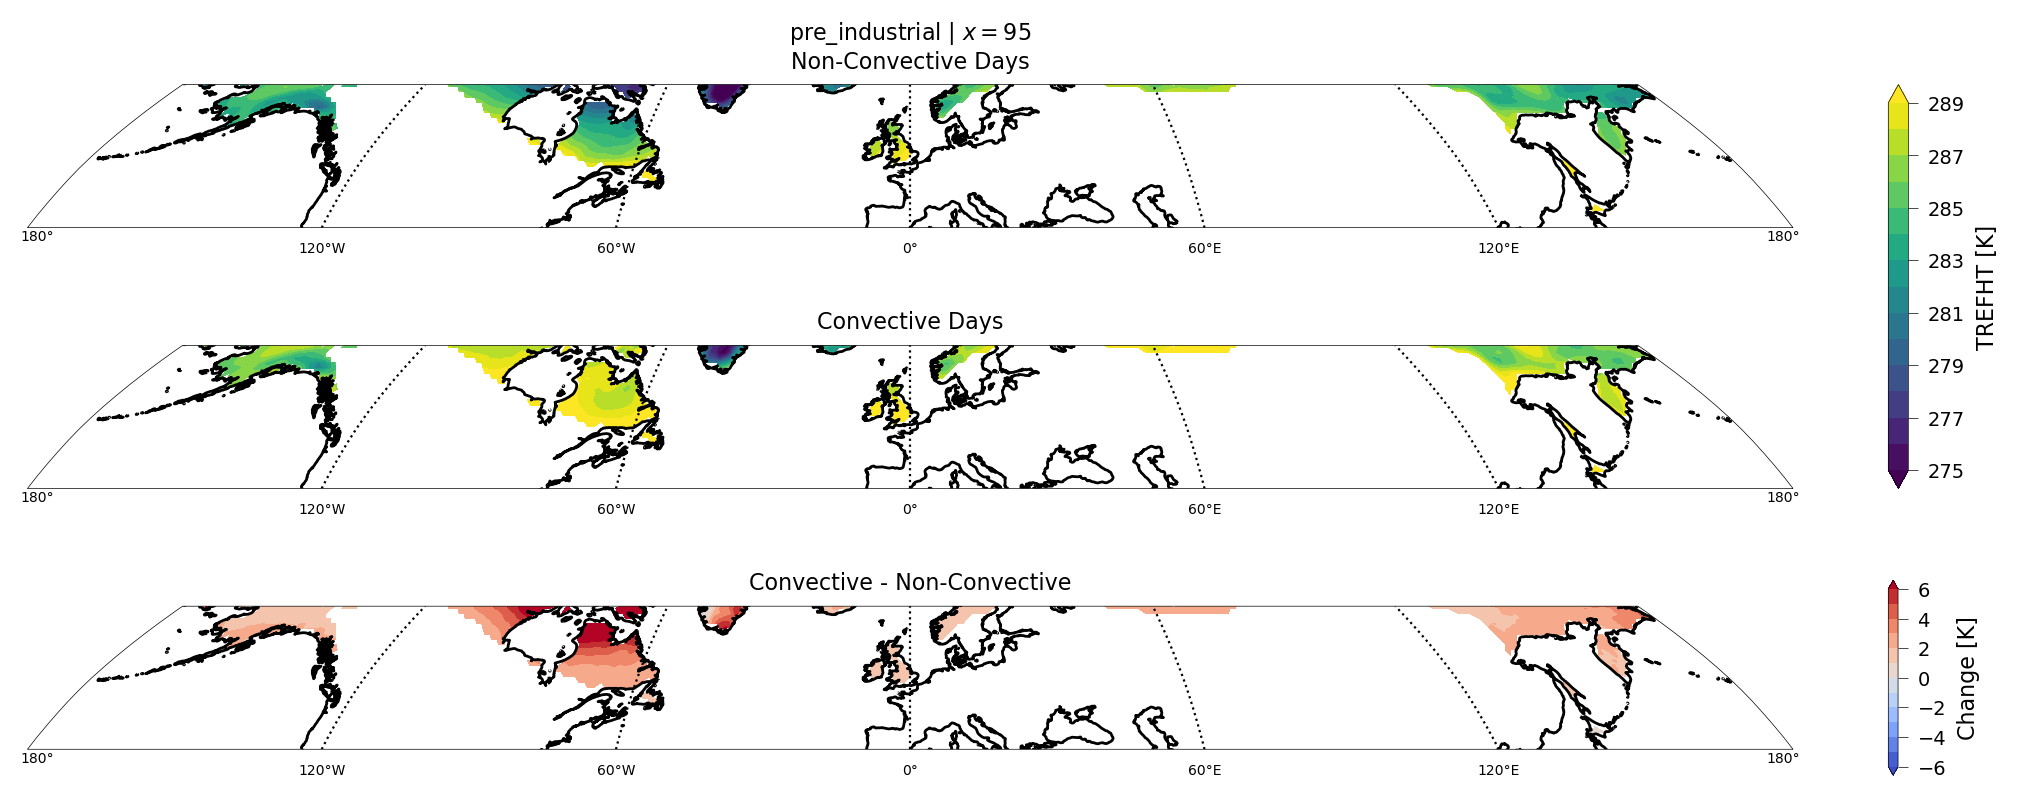

In [14]:
fig = plt.figure(constrained_layout=True,figsize=(10.,4))
ax = fig.subplots(3, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
for i in range(3):
    initialize_ax_projection(ax[i], lat_min=lat_min, lat_max=lat_max)
im = plot_contour_projection(ax[0], (ds.TREFHT.where(~ds.is_conv)).isel(co2=0).mean(dim='sample'), cmap='viridis',
                         mask = land.where(show_conv), levels=np.arange(275, 290, 1))
im = plot_contour_projection(ax[1], (ds.TREFHT.where(ds.is_conv)).isel(co2=0).mean(dim='sample'),
                             cmap='viridis', mask = land.where(show_conv), levels=np.arange(275, 290, 1))
plt.colorbar(im, ax=ax[:2].ravel(), label='TREFHT [K]', shrink=0.8)
im = plot_contour_projection(ax[2], (ds.TREFHT.where(ds.is_conv)).isel(co2=0).mean(dim='sample') -
                             (ds.TREFHT.where(~ds.is_conv)).isel(co2=0).mean(dim='sample'),
                             mask = land.where(show_conv), levels=np.arange(-6, 7, 1), cmap='coolwarm')
plt.colorbar(im, ax=ax[2:].ravel(), label='Change [K]', shrink=0.8)
ax[0].set_title(f"{exp_name[0]} | $x={ds.quant:.0f}$\nNon-Convective Days")
ax[1].set_title(f"Convective Days")
ax[2].set_title("Convective - Non-Convective")
    # ax[i].set_title(f"{exp_name[i]} | $x={ds.quant:.0f}$")
# plt.colorbar(im, ax=ax[:2].ravel(), label='Days convecting [%]', shrink=0.8)
# initialize_ax_projection(ax[2], lat_min=lat_min, lat_max=lat_max)
# im = plot_contour_projection(ax[2], (ds.is_conv.sum(dim='sample')/n_sample).isel(co2=1) * 100 -
#                              (ds.is_conv.sum(dim='sample')/n_sample).isel(co2=0) * 100,
#                              levels=np.arange(-0.7, 0.8, 0.1)*100, cmap='coolwarm', mask = land.where(show_conv))
# plt.colorbar(im, ax=ax[2:].ravel(), label='Change [%]', shrink=0.8)
plt.show()

### Humidity and Lapse rate differences between convective and non convective
Non convective days are more moist and have a smaller lapse rate near the surface i.e. more CIN. These features both would lead to non convective days at the surface being colder if we followed a SQE like profile from the same temperature at 500hPa on convective and non-convective days.

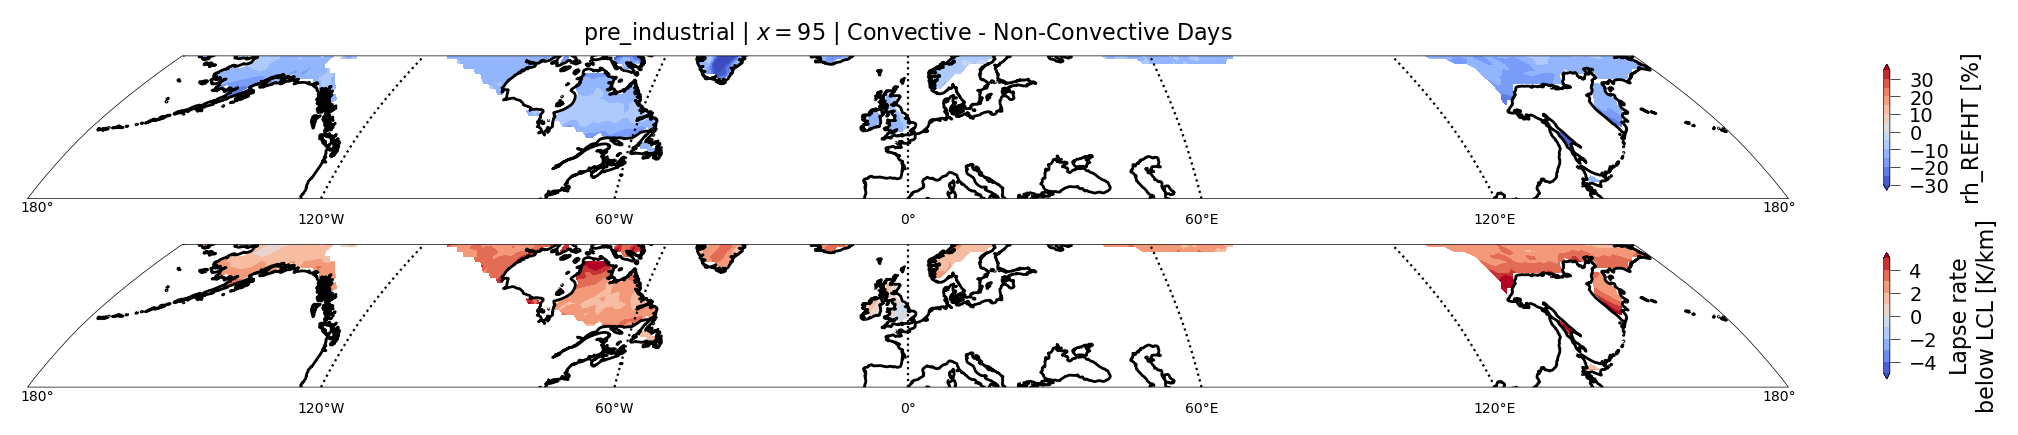

In [15]:
fig = plt.figure(constrained_layout=True,figsize=(10.,2))
ax = fig.subplots(2, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
for i in range(2):
    initialize_ax_projection(ax[i], lat_min=lat_min, lat_max=lat_max)
# im = plot_contour_projection(ax[0], (ds.rh_REFHT.where(~ds.is_conv)).isel(co2=0).mean(dim='sample'), cmap='viridis',
#                          mask = land.where(show_conv), levels=np.arange(275, 290, 1))
# im = plot_contour_projection(ax[1], (ds.TREFHT.where(ds.is_conv)).isel(co2=0).mean(dim='sample'),
#                              cmap='viridis', mask = land.where(show_conv), levels=np.arange(275, 290, 1))
# plt.colorbar(im, ax=ax[:2].ravel(), label='TREFHT [K]', shrink=0.8)
im = plot_contour_projection(ax[0], (ds.rh_REFHT.where(ds.is_conv)).isel(co2=0).mean(dim='sample')*100 -
                             (ds.rh_REFHT.where(~ds.is_conv)).isel(co2=0).mean(dim='sample')*100,
                             mask = land.where(show_conv), levels=np.arange(-30, 40, 5), cmap='coolwarm')
plt.colorbar(im, ax=ax[:1].ravel(), label='rh_REFHT [%]', shrink=0.8)
im = plot_contour_projection(ax[1], (ds.lapse_below_lcl.where(ds.is_conv)).isel(co2=0, plev=0).mean(dim='sample') -
                             (ds.lapse_below_lcl.where(~ds.is_conv)).isel(co2=0, plev=0).mean(dim='sample'),
                             mask = land.where(show_conv), levels=np.arange(-5, 6, 1), cmap='coolwarm')
plt.colorbar(im, ax=ax[1:].ravel(), label='Lapse rate\nbelow LCL [K/km]', shrink=0.8)
ax[0].set_title(f"{exp_name[0]} | $x={ds.quant:.0f}$ | Convective - Non-Convective Days")
# ax[2].set_title("Convective - Non-Convective")
    # ax[i].set_title(f"{exp_name[i]} | $x={ds.quant:.0f}$")
# plt.colorbar(im, ax=ax[:2].ravel(), label='Days convecting [%]', shrink=0.8)
# initialize_ax_projection(ax[2], lat_min=lat_min, lat_max=lat_max)
# im = plot_contour_projection(ax[2], (ds.is_conv.sum(dim='sample')/n_sample).isel(co2=1) * 100 -
#                              (ds.is_conv.sum(dim='sample')/n_sample).isel(co2=0) * 100,
#                              levels=np.arange(-0.7, 0.8, 0.1)*100, cmap='coolwarm', mask = land.where(show_conv))
# plt.colorbar(im, ax=ax[2:].ravel(), label='Change [%]', shrink=0.8)
plt.show()

### Warming trend relative to zonal average
Below, we see that a big chunk of the amplified warming in north east North America is due to non-convective days becoming convective. The change in temperature of the convective days is actually pretty similar to the zonal average.

In [16]:
def get_var_av(var, n_lat_av=30, mask=land>0):
    # rolling average over n_lat_av latitude coordinates
    var_av = var.where(mask).median(dim='lon').rolling(lat=n_lat_av, center=True).median(dim='lat')
    return var_av
# get_var_anom(ds, norm_n_lat, mask=mask).sel(lat=slice(lat_min, lat_max))

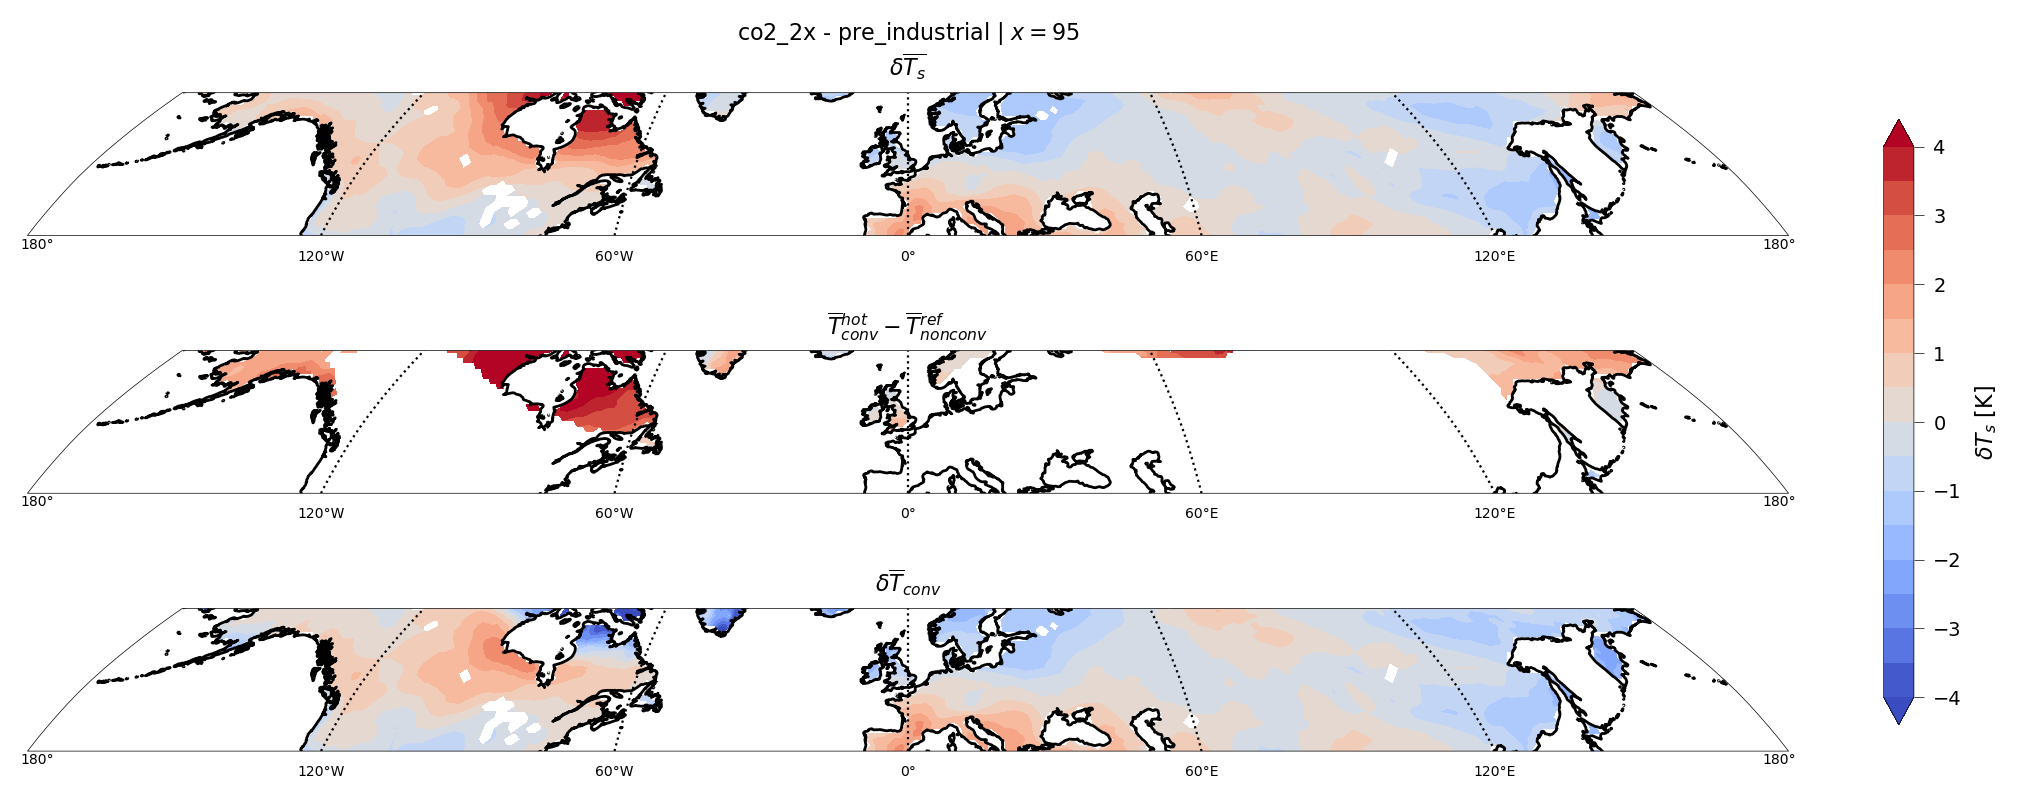

In [17]:
var_change = ds.TREFHT.isel(co2=1).mean(dim='sample') - ds.TREFHT.isel(co2=0).mean(dim='sample')
var_av = get_var_av(var_change)
fig = plt.figure(constrained_layout=True,figsize=(10.,4))
ax = fig.subplots(3, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
for i in range(3):
    initialize_ax_projection(ax[i], lat_min=lat_min, lat_max=lat_max)
im = plot_contour_projection(ax[0], var_change-var_av, cmap='coolwarm', mask=land, levels=np.arange(-4, 4.5, 0.5))
var_change = ds.TREFHT.where(ds.is_conv).isel(co2=1).mean(dim='sample') - \
             ds.TREFHT.where(~ds.is_conv).isel(co2=0).mean(dim='sample')
im = plot_contour_projection(ax[1], var_change-var_av, cmap='coolwarm', mask=land.where(show_conv), levels=np.arange(-4, 4.5, 0.5))
var_change = ds.TREFHT.where(ds.is_conv).isel(co2=1).mean(dim='sample') - \
             ds.TREFHT.where(ds.is_conv).isel(co2=0).mean(dim='sample')
im = plot_contour_projection(ax[2], var_change-var_av, cmap='coolwarm', mask=land, levels=np.arange(-4, 4.5, 0.5))
# im = plot_contour_projection(ax[1], (ds.TREFHT.where(ds.is_conv)).isel(co2=0).mean(dim='sample'),
#                              cmap='viridis', mask = land.where(show_conv), levels=np.arange(275, 290, 1))
# plt.colorbar(im, ax=ax[:2].ravel(), label='TREFHT [K]', shrink=0.8)
# im = plot_contour_projection(ax[2], (ds.TREFHT.where(ds.is_conv)).isel(co2=0).mean(dim='sample') -
#                              (ds.TREFHT.where(~ds.is_conv)).isel(co2=0).mean(dim='sample'),
#                              mask = land.where(show_conv), levels=np.arange(-10, 11, 1), cmap='coolwarm')
plt.colorbar(im, ax=ax.ravel(), label='$\delta T_s$ [K]', shrink=0.8)
ax[0].set_title(f"{exp_name[1]} - {exp_name[0]} | $x={ds.quant:.0f}$\n""$\delta \overline{T_s}$")
ax[1].set_title("$\overline{T}^{hot}_{conv} - \overline{T}^{ref}_{nonconv}$")
ax[2].set_title("$\delta \overline{T}_{conv}$")
    # ax[i].set_title(f"{exp_name[i]} | $x={ds.quant:.0f}$")
# plt.colorbar(im, ax=ax[:2].ravel(), label='Days convecting [%]', shrink=0.8)
# initialize_ax_projection(ax[2], lat_min=lat_min, lat_max=lat_max)
# im = plot_contour_projection(ax[2], (ds.is_conv.sum(dim='sample')/n_sample).isel(co2=1) * 100 -
#                              (ds.is_conv.sum(dim='sample')/n_sample).isel(co2=0) * 100,
#                              levels=np.arange(-0.7, 0.8, 0.1)*100, cmap='coolwarm', mask = land.where(show_conv))
# plt.colorbar(im, ax=ax[2:].ravel(), label='Change [%]', shrink=0.8)
plt.show()

## Principal Component Analysis
Below, I get the principal components over 5 variables that come into the lapse rate coupling, to illustrate their inter-relation. I think it makes most sense to do a spatial normalization first using `do_norm` above. This then answers the question as to why is region A warmer than the zonal average expectation.

In [40]:
# Get variables of interest compared to zonal average
lat_min = 40
lat_max = 65
ds_pca = ds[['T_zonal_av', 'T_anom', 'rh_REFHT5', 'TREFHT', 'T_ft', 'rh_REFHT']]
ds_pca['rh_anom'] = ds_pca['rh_REFHT5'] - ds_pca['rh_REFHT']
ds_pca = ds_pca.where(land.where(ds.is_conv)>0)                             # only consider convecting days
show_conv = (ds.is_conv.sum(dim='sample')/n_sample).min(dim='co2') > 0.5    # only consider regions where most days convecting
ds_pca = ds_pca.where(show_conv)
ds_pca = ds_pca.isel(plev=0)
ds_pca = ds_pca - get_var_av(ds_pca.mean(dim='sample'), n_lat_av=20)
ds_pca = ds_pca.sel(lat=slice(lat_min, lat_max))
# ds_pca = ds_pca.dropna(dim="lat", how="all")
# ds_pca = ds_pca.dropna(dim="lon", how="all")
ds_pca = ds_pca.load()
# Normalise by pre-industrial climate
ds_pca_norm = (ds_pca - ds_pca.isel(co2=0).mean(dim=['sample', 'lat', 'lon'])) / ds_pca.isel(co2=0).std(dim=['sample', 'lat', 'lon'])
ds_pca_norm['TREFHT'] = ds_pca['TREFHT'] * 1        # keep TREFHT as zonal anomaly
# ds_pca_norm['T_zonal_av'] = (ds_pca['T_zonal_av'] - ds_pca['T_ft'].isel(co2=0).mean(dim=['sample', 'lat', 'lon'])
#                         ) / ds_pca['T_ft'].isel(co2=0).std(dim=['sample', 'lat', 'lon'])
# ds_pca_norm['T_anom'] = ds_pca['T_anom'] / ds_pca['T_ft'].isel(co2=0).std(dim=['sample', 'lat', 'lon'])


In [19]:
var_pca = ['T_zonal_av', 'T_anom', 'rh_REFHT5']
keep_ind = [np.where(~np.isnan(ds_pca.T_zonal_av.isel(co2=i).values.flatten()))[0] for i in range(n_exp)]
X = []

for i in range(n_exp):
    X.append(np.column_stack([ds_pca[key].isel(co2=i).values.flatten() for key in var_pca]))

In [20]:
ind_pca_exp = 0         # find PCA using these indices
scaler = StandardScaler()
X_scaled = [np.full_like(X[i], np.nan) for i in range(n_exp)]
X_scaled[ind_pca_exp][keep_ind[ind_pca_exp]] = scaler.fit_transform(X[ind_pca_exp][keep_ind[ind_pca_exp]])

X_lat = (0*ds_pca.T_zonal_av.isel(co2=ind_pca_exp).fillna(0) + ds_pca.lat).values.flatten()
X_lon = (0*ds_pca.T_zonal_av.isel(co2=ind_pca_exp).fillna(0) + ds_pca.lon).values.flatten()
X_trefht = np.asarray([ds_pca.TREFHT.isel(co2=i).fillna(0).values.flatten() for i in range(n_exp)])

In [21]:
n_comp = 3
pca = PCA(n_components=n_comp)
X_pca = [np.full((X[i].shape[0], n_comp), np.nan) for i in range(n_exp)]
X_pca[ind_pca_exp][keep_ind[ind_pca_exp]] = pca.fit_transform(X_scaled[ind_pca_exp][keep_ind[ind_pca_exp]])

# Apply PCA found using ind_pca_exp to other exps
for i in range(n_exp):
    if i == ind_pca_exp:
        continue
    X_scaled[i][keep_ind[i]] = scaler.transform(X[i][keep_ind[i]])          # normalise according to that of ind_pca_exp
    X_pca[i][keep_ind[i]] = pca.transform(X_scaled[i][keep_ind[i]])         # find coefficients in PC space of ind_pca_exp

In [22]:
pbar = tqdm(total=n_exp*ds_pca.lat.size*ds_pca.lon.size)
X_pca_grid = np.full((n_exp, ds_pca.lat.size, ds_pca.lon.size, ds_pca.sample.size, n_comp), np.nan)
for i in range(ds_pca.lat.size):
    for j in range(ds_pca.lon.size):
        ind = np.where(np.logical_and(np.abs(X_lat-ds_pca.lat.values[i])<0.1, np.abs(X_lon-ds_pca.lon.values[j])<0.1))[0]
        if len(ind) == 0:
            pbar.update(n_exp)
            continue
        for k in range(n_exp):
            X_pca_grid[k, i, j, :len(ind)] = X_pca[k][ind]
            pbar.update(1)
pbar.close()
X_pca_grid = xr.DataArray(
    X_pca_grid,
    dims=('co2', 'lat', 'lon', 'sample', 'pc'),
    coords={'co2': ds_pca.co2, 'lat': ds_pca.lat, 'lon': ds_pca.lon, 'sample': ds_pca.sample, 'pc': np.arange(n_comp)},
    name='pc_coef'
)

  0%|          | 0/15552 [00:00<?, ?it/s]

In [23]:
loadings = pca.components_.T  # shape: (variables, components)

for i, pc_loadings in enumerate(loadings.T, 1):
    print(f"\nPC{i} loadings (var explained = {pca.explained_variance_ratio_[i-1]:.2f}):")
    for var, loading in zip(var_pca, pc_loadings):
        print(f"  {var:20s}: {loading:.2f}")


PC1 loadings (var explained = 0.47):
  T_zonal_av          : -0.69
  T_anom              : 0.72
  rh_REFHT5           : 0.08

PC2 loadings (var explained = 0.36):
  T_zonal_av          : 0.32
  T_anom              : 0.21
  rh_REFHT5           : 0.93

PC3 loadings (var explained = 0.18):
  T_zonal_av          : -0.65
  T_anom              : -0.67
  rh_REFHT5           : 0.37


### Single Climate

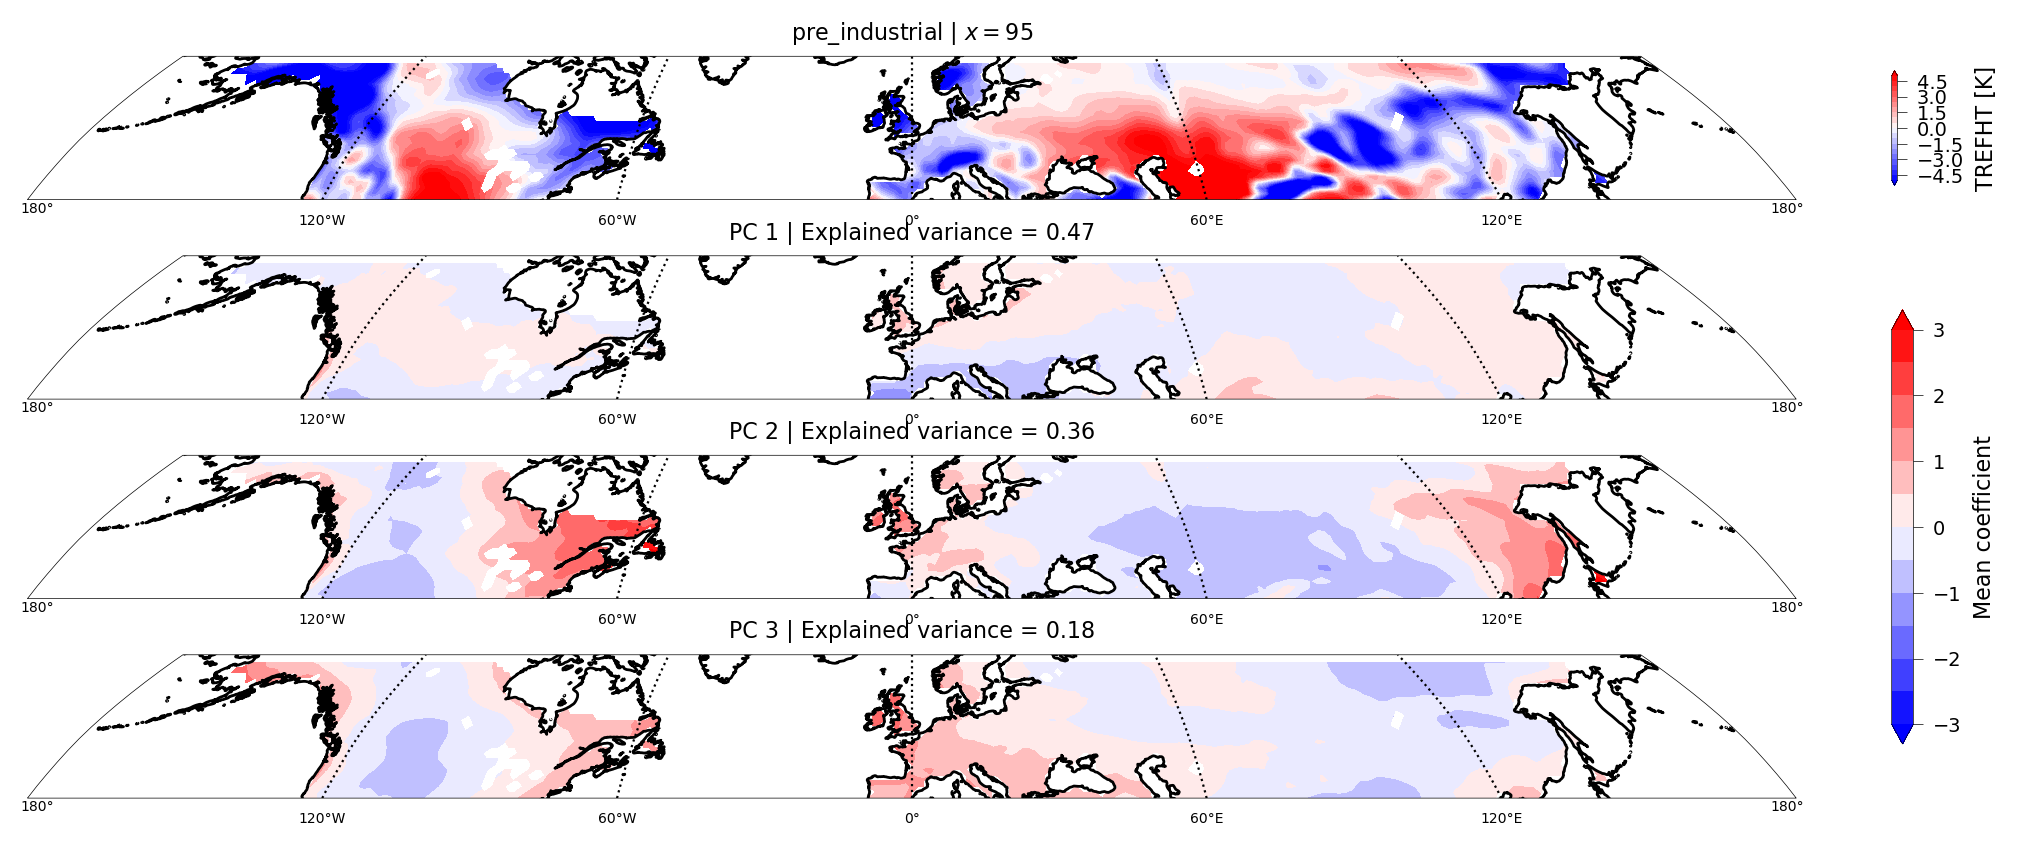

In [24]:
j = 0
fig = plt.figure(constrained_layout=True,figsize=(10.,4))
ax = fig.subplots(n_comp+1, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
initialize_ax_projection(ax[0], lat_min=lat_min, lat_max=lat_max)
im = plot_contour_projection(ax[0], ds_pca.TREFHT.isel(co2=j).mean(dim='sample'), levels=np.arange(-5, 5.5, 0.5),
                             cmap='bwr')
plt.colorbar(im, ax=ax[0], label='TREFHT [K]', shrink=0.8)
for i in range(n_comp):
    initialize_ax_projection(ax[i+1], lat_min=lat_min, lat_max=lat_max)
    im = plot_contour_projection(ax[i+1], X_pca_grid.isel(co2=j, pc=i).mean(dim='sample'), levels=np.arange(-3, 3.5, 0.5), cmap='bwr')
    ax[i+1].set_title(f'PC {i+1} | Explained variance = {pca.explained_variance_ratio_[i]:.2f}')
plt.colorbar(im, ax=ax[1:].ravel(), label='Mean coefficient', shrink=0.8)
ax[0].set_title(f"{exp_name[j]} | $x={ds.quant:.0f}$")
plt.show()

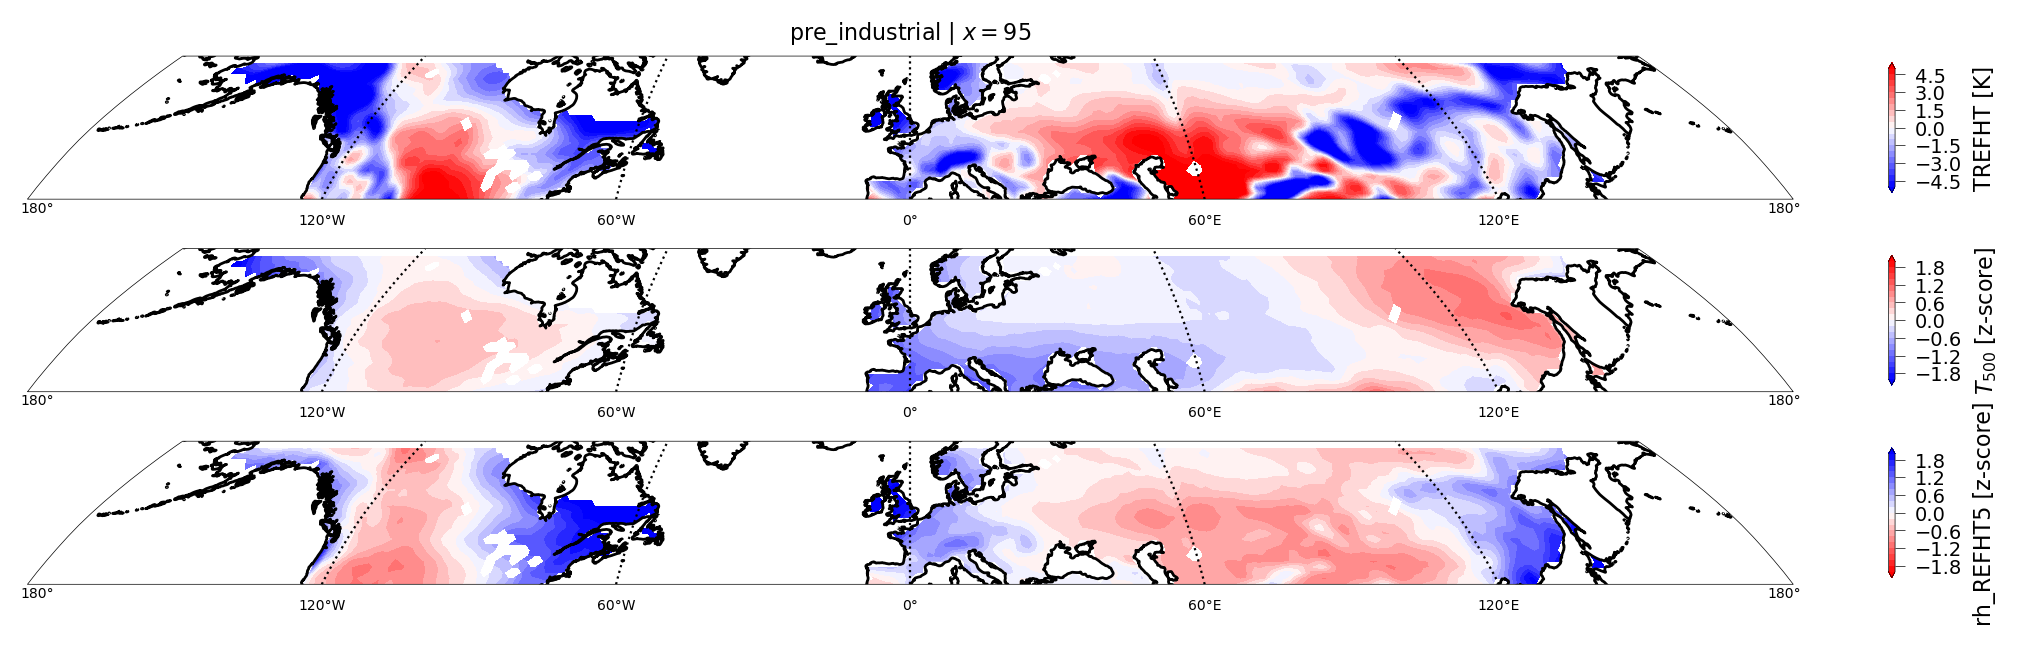

In [25]:
j = 0
fig = plt.figure(constrained_layout=True,figsize=(10.,3))
ax = fig.subplots(3, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
initialize_ax_projection(ax[0], lat_min=lat_min, lat_max=lat_max)
im = plot_contour_projection(ax[0], ds_pca.TREFHT.isel(co2=j).mean(dim='sample'), levels=np.arange(-5, 5.5, 0.5),
                             cmap='bwr')
plt.colorbar(im, ax=ax[0], label='TREFHT [K]', shrink=0.8)

initialize_ax_projection(ax[1], lat_min=lat_min, lat_max=lat_max)
im = plot_contour_projection(ax[1], ds_pca_norm.T_ft.isel(co2=j).mean(dim='sample'), levels=np.arange(-2, 2.2, 0.2),
                             cmap='bwr')
plt.colorbar(im, ax=ax[1], label='$T_{500}$ [z-score]', shrink=0.8)

initialize_ax_projection(ax[2], lat_min=lat_min, lat_max=lat_max)
im = plot_contour_projection(ax[2], ds_pca_norm.rh_REFHT5.isel(co2=j).mean(dim='sample'), levels=np.arange(-2, 2.2, 0.2),
                             cmap='bwr_r')
plt.colorbar(im, ax=ax[2], label='rh_REFHT5 [z-score]', shrink=0.8)
ax[0].set_title(f"{exp_name[j]} | $x={ds.quant:.0f}$")
plt.show()

### Change with warming

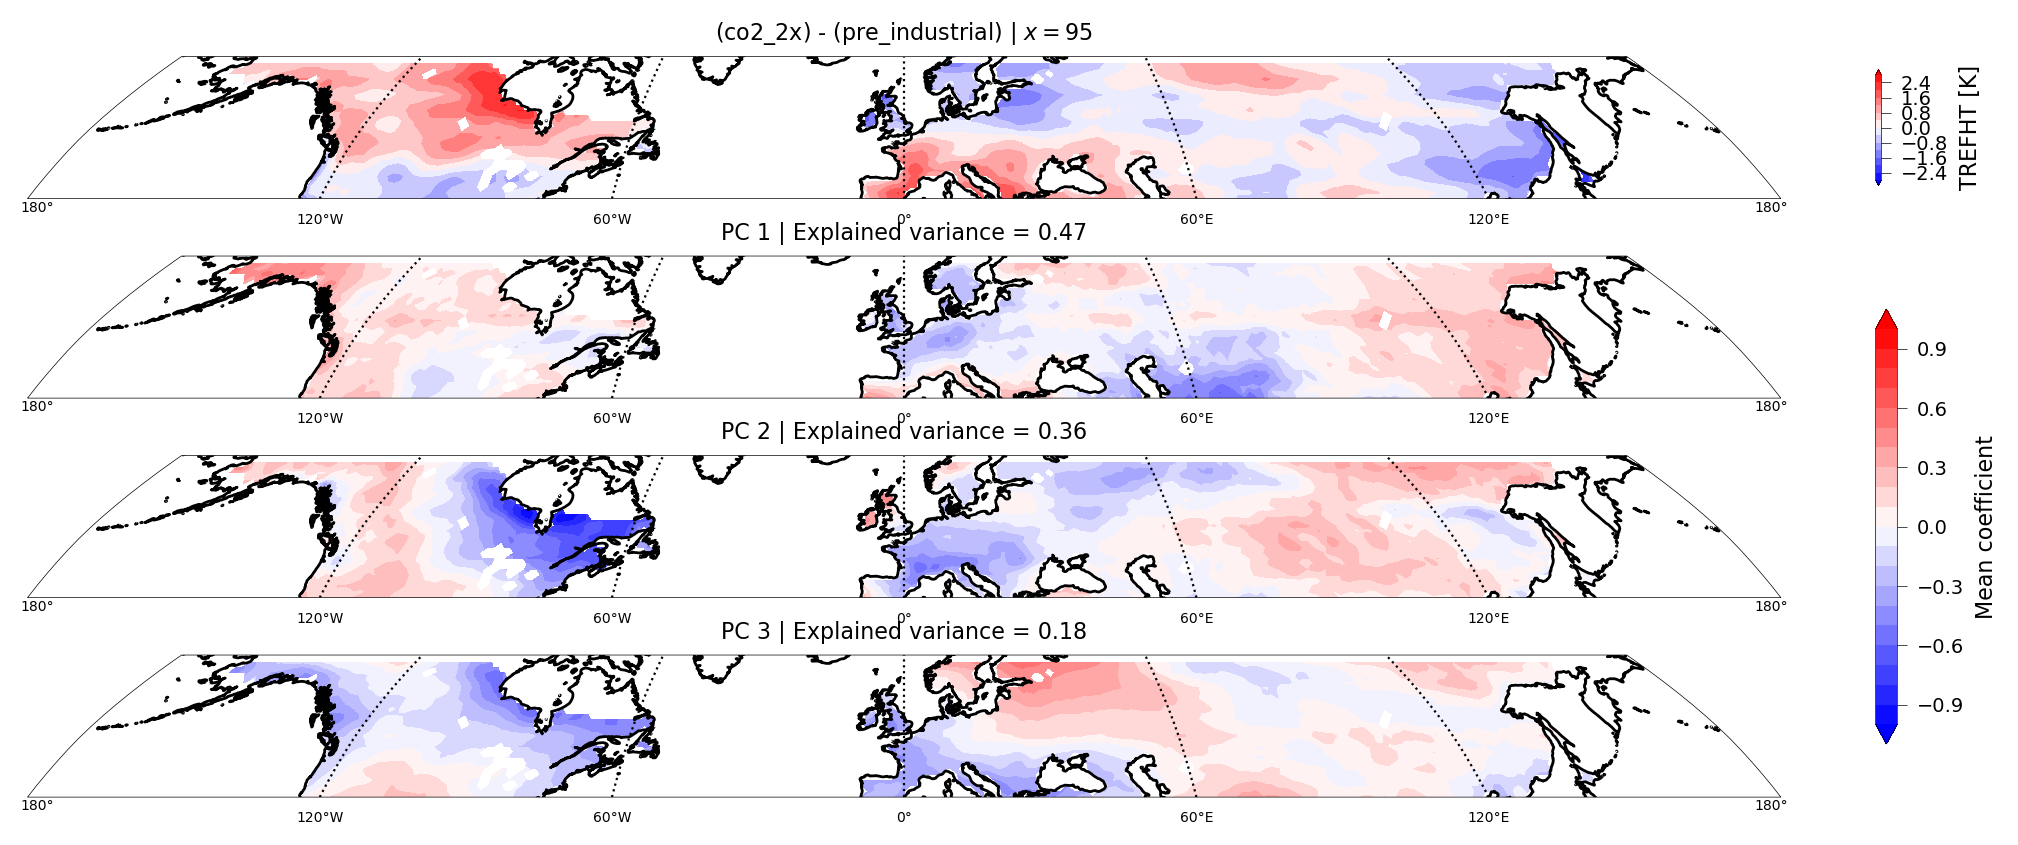

In [26]:
fig = plt.figure(constrained_layout=True,figsize=(10.,4))
ax = fig.subplots(n_comp+1, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
initialize_ax_projection(ax[0], lat_min=lat_min, lat_max=lat_max)
im = plot_contour_projection(ax[0], ds_pca.TREFHT.isel(co2=1).mean(dim='sample') - ds_pca.TREFHT.isel(co2=0).mean(dim='sample'),
                             levels=np.arange(-2.8, 3, 0.4),
                             cmap='bwr')
plt.colorbar(im, ax=ax[0], label='TREFHT [K]', shrink=0.8)
for i in range(n_comp):
    initialize_ax_projection(ax[i+1], lat_min=lat_min, lat_max=lat_max)
    im = plot_contour_projection(ax[i+1], X_pca_grid.isel(co2=1, pc=i).mean(dim='sample') -
                                 X_pca_grid.isel(co2=0, pc=i).mean(dim='sample'), levels=np.arange(-1, 1.1, 0.1), cmap='bwr')
    ax[i+1].set_title(f'PC {i+1} | Explained variance = {pca.explained_variance_ratio_[i]:.2f}')
plt.colorbar(im, ax=ax[1:].ravel(), label='Mean coefficient', shrink=0.8)
ax[0].set_title(f"({exp_name[1]}) - ({exp_name[0]}) | $x={ds.quant:.0f}$")
plt.show()

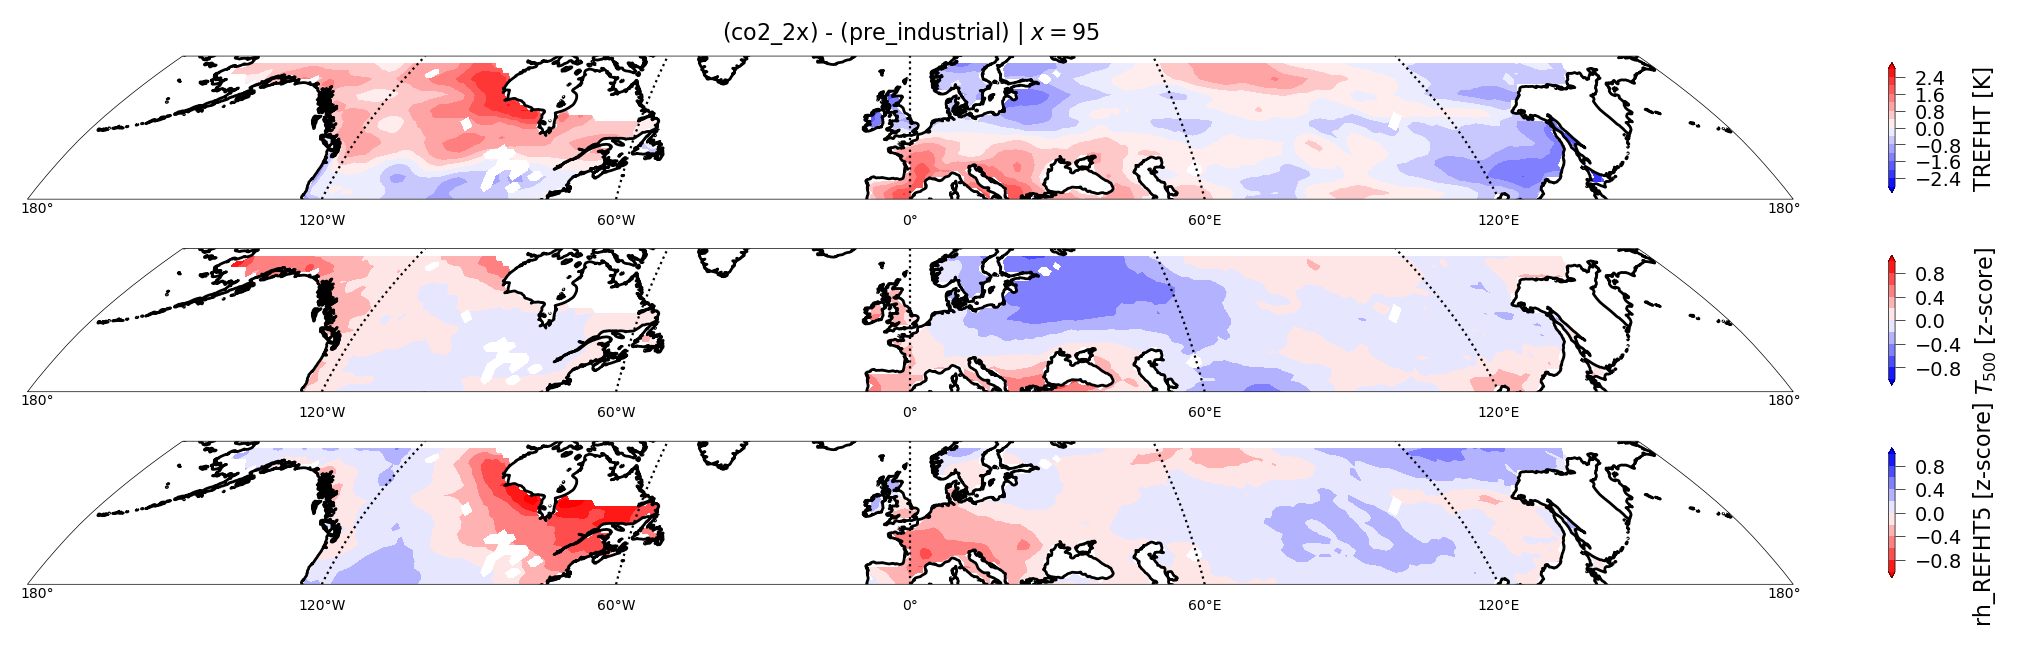

In [27]:
j = 0
fig = plt.figure(constrained_layout=True,figsize=(10.,3))
ax = fig.subplots(3, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
initialize_ax_projection(ax[0], lat_min=lat_min, lat_max=lat_max)
im = plot_contour_projection(ax[0], ds_pca.TREFHT.isel(co2=1).mean(dim='sample') - ds_pca.TREFHT.isel(co2=0).mean(dim='sample'),
                             levels=np.arange(-2.8, 3, 0.4), cmap='bwr')
plt.colorbar(im, ax=ax[0], label='TREFHT [K]', shrink=0.8)

initialize_ax_projection(ax[1], lat_min=lat_min, lat_max=lat_max)
im = plot_contour_projection(ax[1], ds_pca_norm.T_ft.isel(co2=1).mean(dim='sample') -
                             ds_pca_norm.T_ft.isel(co2=0).mean(dim='sample'), levels=np.arange(-1, 1.2, 0.2), cmap='bwr')
plt.colorbar(im, ax=ax[1], label='$T_{500}$ [z-score]', shrink=0.8)

initialize_ax_projection(ax[2], lat_min=lat_min, lat_max=lat_max)
im = plot_contour_projection(ax[2], ds_pca_norm.rh_REFHT5.isel(co2=1).mean(dim='sample') -
                             ds_pca_norm.rh_REFHT5.isel(co2=0).mean(dim='sample'), levels=np.arange(-1, 1.2, 0.2), cmap='bwr_r')
plt.colorbar(im, ax=ax[2], label='rh_REFHT5 [z-score]', shrink=0.8)
ax[0].set_title(f"({exp_name[1]}) - ({exp_name[0]}) | $x={ds.quant:.0f}$")
plt.show()

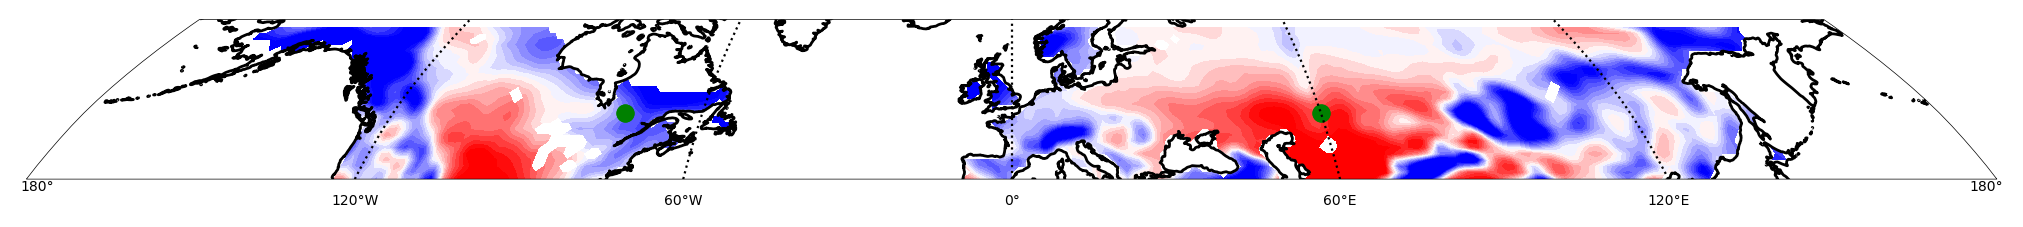

In [28]:
j = 0
show_plot_loc = True
fig = plt.figure(constrained_layout=True,figsize=(10.,4))
ax = fig.subplots(1,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
initialize_ax_projection(ax, lat_min=lat_min, lat_max=lat_max)
plot_contour_projection(ax, ds_pca.TREFHT.mean(dim='sample').isel(co2=j), levels=np.arange(-5, 5.5, 0.5),
                             cmap='bwr')
lon_plot = [60, 285]
lat_plot = [50, 50]
for i in range(len(lon_plot)):
    ax.scatter(lon_plot, lat_plot, s=50, marker='.', c='g', lw=3, alpha=1, transform=ccrs.PlateCarree())
if show_plot_loc:
    plt.show()
else:
    plt.close()

In [29]:
# Function to extract ellipse parameters
def ellipse_params(x, y):
    points = np.column_stack([x, y])
    pca = PCA(n_components=2)
    pca.fit(points)
    center = np.mean(points, axis=0)

    # 1 std dev scaling
    width, height = 2 * np.sqrt(pca.explained_variance_)

    # Orientation angle
    angle = np.degrees(np.arctan2(*pca.components_[0][::-1]))

    aspect_ratio = width / height
    return {
        "center": center,
        "width": width,
        "height": height,
        "angle": angle,
        "aspect_ratio": aspect_ratio
    }

{'center': array([-0.81615282, -0.33837107]), 'width': 1.309120243767287, 'height': 0.7446501051853738, 'angle': -113.63444659124865, 'aspect_ratio': 1.7580340547207653}
{'center': array([1.56455052, 0.16879895]), 'width': 1.9019965740131273, 'height': 1.4312762894526079, 'angle': -140.33890136425933, 'aspect_ratio': 1.3288814941107887}


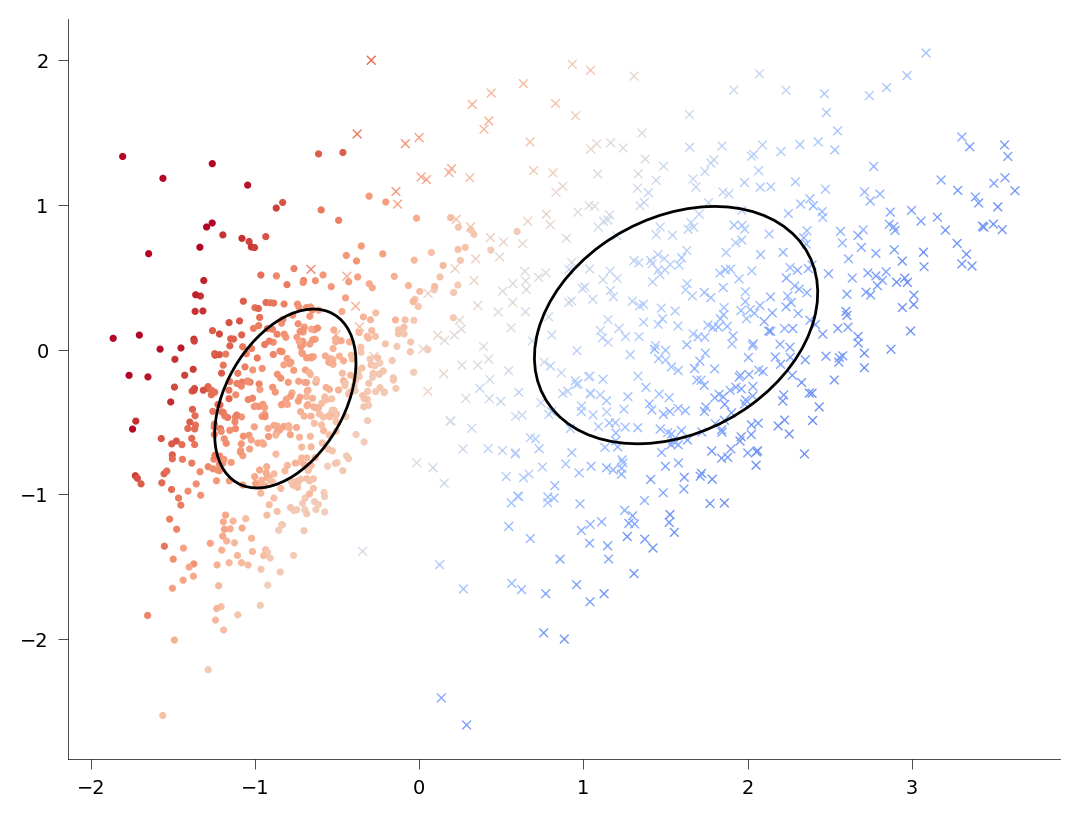

In [30]:
ds_use = lat_lon_coord_slice(ds_pca_norm, lat=lat_plot, lon=lon_plot).isel(co2=0)
for i in range(len(lon_plot)):
    params = ellipse_params(ds_use.isel(location=i).rh_REFHT5.dropna(dim='sample'), ds_use.isel(location=i).T_ft.dropna(dim='sample'))
    print(params)
    plt.scatter(ds_use.isel(location=i).rh_REFHT5.dropna(dim='sample'), ds_use.isel(location=i).T_ft.dropna(dim='sample'), marker=['.', 'x'][i], s=10,
                c=ds_use.isel(location=i).TREFHT.dropna(dim='sample'), vmin=-8, vmax=8, cmap='coolwarm')
    ellipse = Ellipse(
        xy=params["center"],
        width=params["width"], height=params["height"],
        angle=params["angle"],
        edgecolor=f'k', facecolor="none", lw=1
    )
    plt.gca().add_patch(ellipse)

### Example different warming at same latitude
This is the opposite to the drier get hotter we might expect.

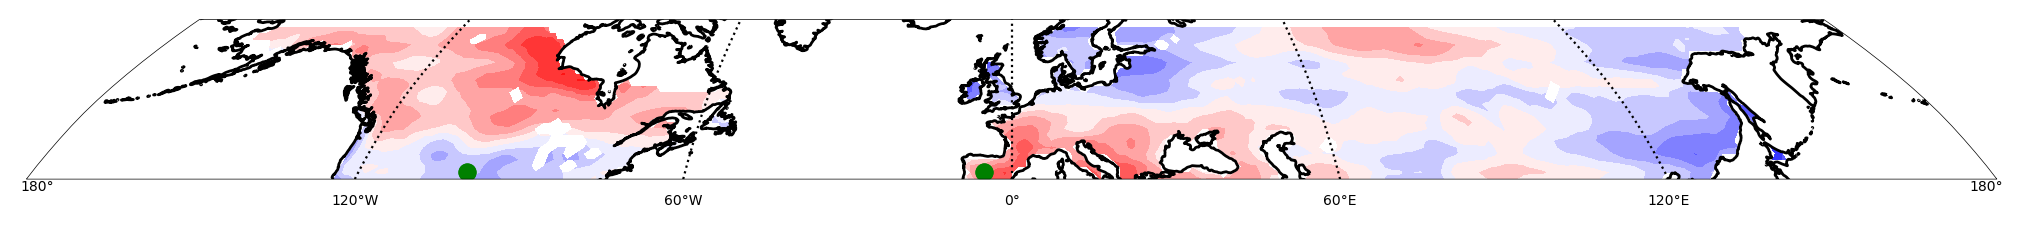

In [31]:
show_plot_loc = True
fig = plt.figure(constrained_layout=True,figsize=(10.,4))
ax = fig.subplots(1,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0})
initialize_ax_projection(ax, lat_min=lat_min, lat_max=lat_max)
plot_contour_projection(ax, ds_pca.TREFHT.mean(dim='sample').isel(co2=1)-ds_pca.TREFHT.mean(dim='sample').isel(co2=0), levels=np.arange(-2.8, 3, 0.4),
                             cmap='bwr')
lon_plot = [355, 260]
lat_plot = [41, 41]
for i in range(len(lon_plot)):
    ax.scatter(lon_plot, lat_plot, s=50, marker='.', c='g', lw=3, alpha=1, transform=ccrs.PlateCarree())
if show_plot_loc:
    plt.show()
else:
    plt.close()

{'center': array([-0.12597085, -1.17941799]), 'width': 1.5511550010271193, 'height': 0.5153363407317567, 'angle': -118.75714763783236, 'aspect_ratio': 3.0099856703770245}
{'center': array([-0.25696659, -0.83404374]), 'width': 1.7487109439562922, 'height': 0.4055243106671506, 'angle': -115.26607527631229, 'aspect_ratio': 4.312222221842608}
{'center': array([-0.82294597,  0.40593803]), 'width': 1.2728306979053807, 'height': 0.4585445361407135, 'angle': -111.7408701185544, 'aspect_ratio': 2.775806050635804}
{'center': array([-0.62906162,  0.24228446]), 'width': 1.2149444303027033, 'height': 0.42503865863459417, 'angle': -110.18715627295312, 'aspect_ratio': 2.8584327698699785}


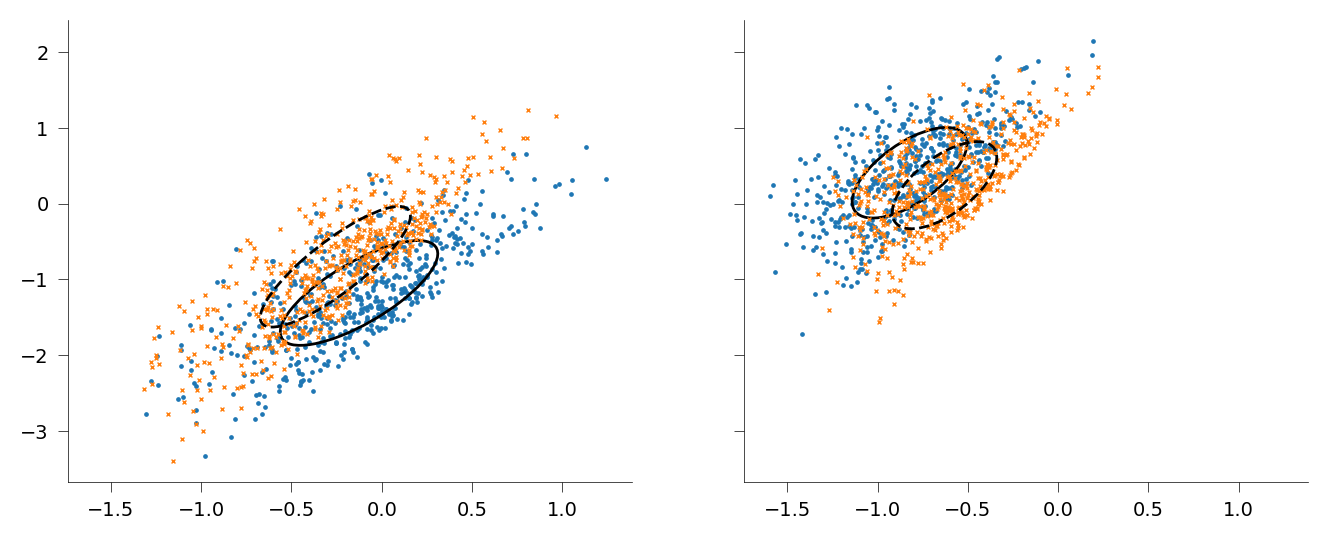

In [32]:
ds_use = lat_lon_coord_slice(ds_pca_norm, lat=lat_plot, lon=lon_plot)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, 4*2)
for i in range(len(lon_plot)):
    for j in range(n_exp):
        params = ellipse_params(ds_use.isel(location=i, co2=j).rh_REFHT5.dropna(dim='sample'),
                                ds_use.isel(location=i, co2=j).T_ft.dropna(dim='sample'))
        print(params)
        # ax[i].scatter(ds_use.isel(location=i, co2=j).rh_REFHT5, ds_use.isel(location=i, co2=j).T_ft, marker=['.', 'x'][j], s=4,
        #             c=ds_use.isel(location=i, co2=j).TREFHT, vmin=-8, vmax=8, cmap='coolwarm')
        ax[i].scatter(ds_use.isel(location=i, co2=j).rh_REFHT5, ds_use.isel(location=i, co2=j).T_ft, marker=['.', 'x'][j], s=2,
                      color=f"C{j}")
        ellipse = Ellipse(
            xy=params["center"],
            width=params["width"], height=params["height"],
            angle=params["angle"],
            edgecolor=f'k', facecolor="none", lw=1, linestyle=['-', '--'][j]
        )
        ax[i].add_patch(ellipse)

{'center': array([ 0.21050298, -1.43751727]), 'width': 1.4066263461684634, 'height': 0.9740276863316822, 'angle': 112.79385833547997, 'aspect_ratio': 1.444133843326369}
{'center': array([ 0.19682804, -1.07036841]), 'width': 1.413148761730927, 'height': 0.9453256049461569, 'angle': -90.05147212253937, 'aspect_ratio': 1.49488044578187}
{'center': array([0.22788452, 0.15730692]), 'width': 1.2154589357504766, 'height': 0.9093833028418641, 'angle': -55.17459666742698, 'aspect_ratio': 1.3365749425485516}
{'center': array([ 0.23854795, -0.01230768]), 'width': 1.2861318281308463, 'height': 0.793524333190297, 'angle': 115.65860835177034, 'aspect_ratio': 1.6207843595168188}


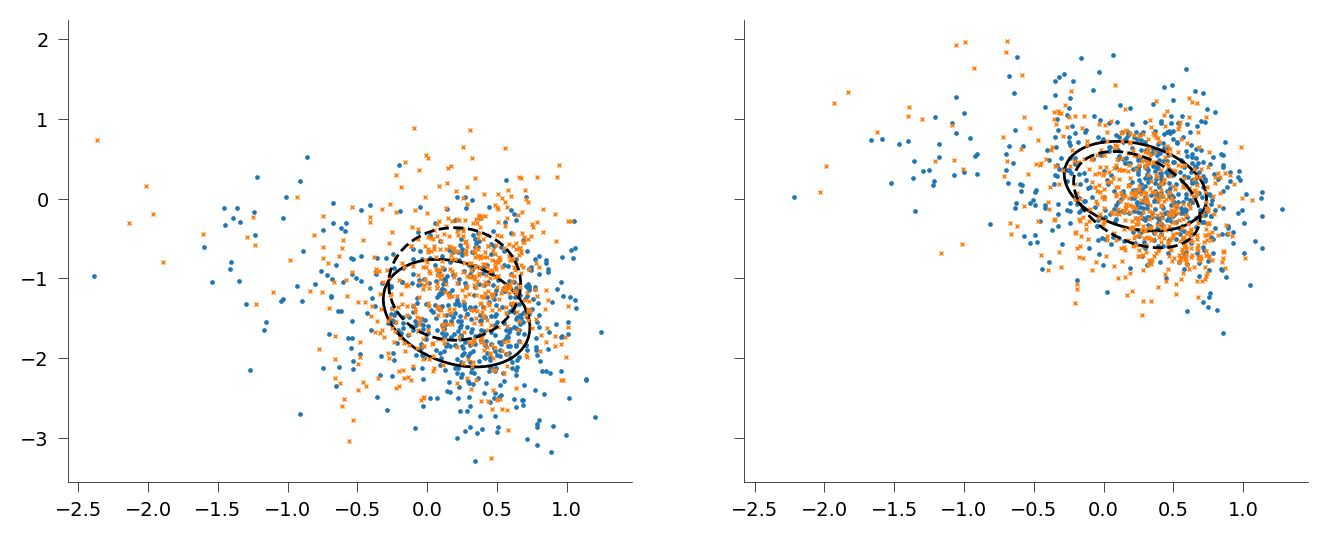

In [36]:
ds_use = lat_lon_coord_slice(ds_pca_norm, lat=lat_plot, lon=lon_plot)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, 4*2)
for i in range(len(lon_plot)):
    for j in range(n_exp):
        params = ellipse_params(ds_use.isel(location=i, co2=j).T_zonal_av.dropna(dim='sample'),
                                ds_use.isel(location=i, co2=j).T_anom.dropna(dim='sample'))
        print(params)
        # ax[i].scatter(ds_use.isel(location=i, co2=j).rh_REFHT5, ds_use.isel(location=i, co2=j).T_ft, marker=['.', 'x'][j], s=4,
        #             c=ds_use.isel(location=i, co2=j).TREFHT, vmin=-8, vmax=8, cmap='coolwarm')
        ax[i].scatter(ds_use.isel(location=i, co2=j).T_zonal_av, ds_use.isel(location=i, co2=j).T_anom, marker=['.', 'x'][j], s=2,
                      color=f"C{j}")
        ellipse = Ellipse(
            xy=params["center"],
            width=params["width"], height=params["height"],
            angle=params["angle"],
            edgecolor=f'k', facecolor="none", lw=1, linestyle=['-', '--'][j]
        )
        ax[i].add_patch(ellipse)

{'center': array([ 0.06341016, -0.28889848]), 'width': 1.1542035966051254, 'height': 0.6219058233604289, 'angle': 115.49522220111365, 'aspect_ratio': 1.8559137947421993}
{'center': array([-0.17781344, -0.08040075]), 'width': 1.007544444588213, 'height': 0.5651736208055202, 'angle': -71.54397048881913, 'aspect_ratio': 1.782716686515196}
{'center': array([-0.30261341, -0.6594186 ]), 'width': 1.0789028063905, 'height': 0.43464439029821295, 'angle': -45.67166212987737, 'aspect_ratio': 2.482265572667937}
{'center': array([-0.22845417, -0.4889719 ]), 'width': 0.871828264289195, 'height': 0.41071119542783074, 'angle': 132.56844652169002, 'aspect_ratio': 2.1227282674411314}


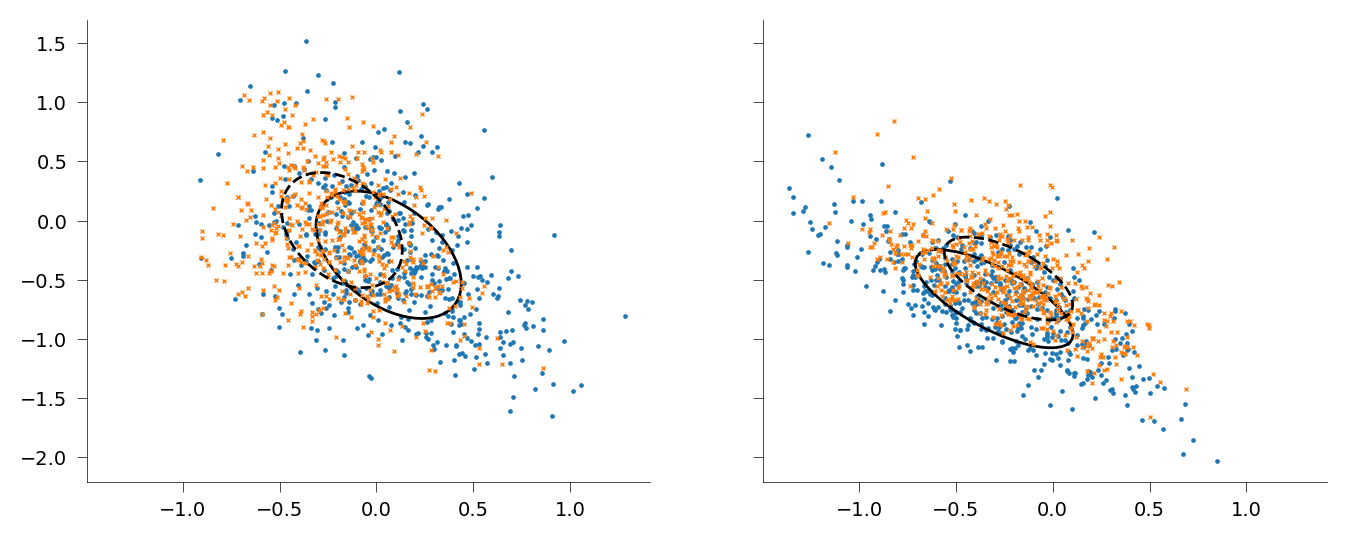

In [41]:
ds_use = lat_lon_coord_slice(ds_pca_norm, lat=lat_plot, lon=lon_plot)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, 4*2)
for i in range(len(lon_plot)):
    for j in range(n_exp):
        params = ellipse_params(ds_use.isel(location=i, co2=j).rh_REFHT.dropna(dim='sample'),
                                ds_use.isel(location=i, co2=j).rh_anom.dropna(dim='sample'))
        print(params)
        # ax[i].scatter(ds_use.isel(location=i, co2=j).rh_REFHT5, ds_use.isel(location=i, co2=j).T_ft, marker=['.', 'x'][j], s=4,
        #             c=ds_use.isel(location=i, co2=j).TREFHT, vmin=-8, vmax=8, cmap='coolwarm')
        ax[i].scatter(ds_use.isel(location=i, co2=j).rh_REFHT, ds_use.isel(location=i, co2=j).rh_anom, marker=['.', 'x'][j], s=2,
                      color=f"C{j}")
        ellipse = Ellipse(
            xy=params["center"],
            width=params["width"], height=params["height"],
            angle=params["angle"],
            edgecolor=f'k', facecolor="none", lw=1, linestyle=['-', '--'][j]
        )
        ax[i].add_patch(ellipse)

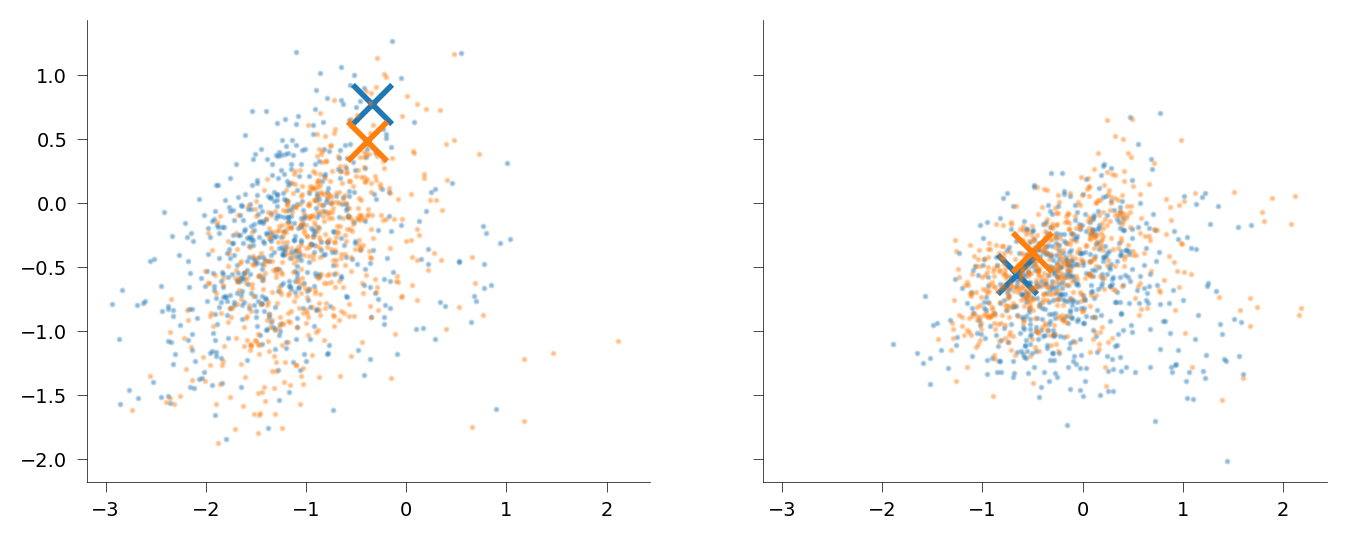

In [33]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, 4*2)
for i in range(len(lon_plot)):
    plot_ind = np.logical_and(np.abs(X_lat-lat_plot[i])<0.7, np.abs(X_lon-lon_plot[i])<0.7)
    for j in range(n_exp):
        ax[i].scatter(X_pca[j][plot_ind, 0], X_pca[j][plot_ind, 1], s=5, color=f"C{j}", marker='.', alpha=0.3)
        ax[i].scatter(np.mean(X_pca[j][plot_ind, 1]), np.mean(X_pca[j][plot_ind, 2]), s=200, color=f"C{j}", marker='x', lw=2)

In [34]:
i=0
plot_ind = np.logical_and(np.abs(X_lat-lat_plot[i])<0.7, np.abs(X_lon-lon_plot[i])<0.7)
X_scaled[0][plot_ind, -1].mean()

-0.12586479

In [35]:
i=1
plot_ind = np.logical_and(np.abs(X_lat-lat_plot[i])<0.7, np.abs(X_lon-lon_plot[i])<0.7)
X_scaled[0][plot_ind, -1].mean()

-0.8222525